In [1]:
#@title
# Use a fixed configuration, more likely to keep working on Colab.
%tensorflow_version 2.0
!pip uninstall -y keras
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.datasets.mnist import load_data

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
#@title
%cd /content
!rm -rf remap_image
!git clone https://github.com/LanceNorskog/remap_image.git
%cd /content/remap_image
import scurve.scurve as scurve
import numpy as np

side = 28
power2 = 2 ** int(np.floor(np.sqrt(28)))
map = scurve.fromSize('hilbert', 2, power2 * power2)
def get_reverse_index(index, power2):
    xy = map.point(index)
    return xy[0] * power2 + xy[1]

def pad_image(image, power2):
    padded = np_zeros((power2 * power2, power2 * power2))
    padded[0:images.shape[1]] = images[i]
    return padded

def remap(images, tiling, inverted=False):
    side = images.shape[-1]
    power2 = 2 ** int(np.floor(np.sqrt(side) + 0.49))
    if power2 == side * 2:
        power2 = side
            
    h_indexes = np.arange(0, (power2 * power2), dtype='int32')
    h_indexes_inverted = np.arange(0, (power2 * power2), dtype='int32')
    if tiling != 'flyback':
        for index in range(power2 * power2):
            h_indexes[index] = get_reverse_index(index, power2)
        for x in range(power2):
            for y in range(power2):
                h_indexes_inverted[x * side + y] = map.index([x, y])        
    tiles = np.zeros((images.shape[0], power2, power2))
    for i in range(images.shape[0]):
        padded = np.reshape(np.pad(images[i], (0, power2-side), mode='constant', constant_values=(0)), (power2*power2))
        if not inverted:
            tiles[i] = np.reshape(padded[h_indexes], (power2, power2))
        else:
            tiles[i] = np.reshape(padded[h_indexes_inverted], (power2, power2))
    return tiles

/content
Cloning into 'remap_image'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 97 (delta 43), reused 48 (delta 16), pack-reused 0
Unpacking objects: 100% (97/97), done.
/content/remap_image


In [0]:
# code to view the images
def display1(digits, labels):
    num_cols = len(digits)
    plt.clf()
    f, ax = plt.subplots(1, num_cols, figsize=(11,5),
                        gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                        squeeze=True)

    for c in range(num_cols):
            ax[c].axis("off")
            ax[c].imshow(digits[c], cmap='gray')
            ax[c].set_title('No. %s' % str(labels[c]))
    plt.show()
    plt.close()

In [0]:
#@title
from tensorflow.keras.models import Sequential
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train / 255.0)
x_test = (x_test / 255.0)

square=32
batchsize=32
activation='tanh'
activation2='sigmoid'
neighborhood = 1
steps = (square * square) // neighborhood
num_train=60000
num_test=10000
epochs_list = [30, 50]
max_acc = 0.9
dropout=0.2

use_cached = False

In [0]:
#@title
def train(units, tiling, epochs=30):
    x_train1 = remap(x_train[0:num_train], tiling)
    x_test1 = remap(x_test[0:num_test], tiling)
    pix_in = remap(x_test[0:7], tiling)
    labels = y_test[0:7]

    model = Sequential()
    model.add(layers.Input(shape=(x_train1.shape[1:])))
    model.add(layers.Reshape((steps, neighborhood)))
    model.add(layers.LSTM(units, activation=activation, return_sequences=True))
    model.add(layers.Dropout(dropout))
    model.add(layers.LSTM(units, activation=activation, return_sequences=True))
    model.add(layers.Dropout(dropout))
    model.add(layers.TimeDistributed(layers.Dense(neighborhood, activation=activation2)))
    model.add(layers.Reshape((square, square)))
    model.add(layers.Dropout(dropout))
    opt = tf.keras.optimizers.Adam(lr=0.0001) #, decay=1e-5)
    model.compile(loss='mse', optimizer=opt,
                metrics=['accuracy'])
    history = model.fit(x_train1, x_train1, epochs=epochs, validation_split=0.2,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.00015, verbose=1, patience=2, restore_best_weights=True)],
                batch_size=batchsize, verbose=2)
    eval = model.evaluate(x=x_test1, y=x_test1, batch_size=256)
    pix_out = model.predict(pix_in)
    images = remap(pix_out, tiling, inverted=True)
    return {'units':str(units), 'tiling':tiling, 'history':history.history, 'test_loss': eval[0], 'test_accuracy': eval[1], 'pix':images, 'labels':labels}

In [6]:
# This notebook takes several hours to run on Colab, and Colab will probably kill it as a Bitcoin miner.
# Store cached data and plot that.
allhist = {}
models = {}
for units in [1,2,4,8,16]:
    allhist[units] = {}
    models[units] = {}
    for tiling in ['flyback', 'hilbert']:
        print('Units=%d, Tiling=%s' % (units, tiling))
        if not (units in allhist and tiling in allhist[units]):
            allhist[units][tiling] = train(units, tiling, epochs=5)
    

Units=1, Tiling=flyback
Epoch 1/5
1500/1500 - 83s - loss: 0.1887 - accuracy: 0.0748 - val_loss: 0.1071 - val_accuracy: 0.2888
Epoch 2/5
1500/1500 - 83s - loss: 0.1273 - accuracy: 0.0743 - val_loss: 0.0861 - val_accuracy: 0.2884
Epoch 3/5
1500/1500 - 83s - loss: 0.1128 - accuracy: 0.0744 - val_loss: 0.0791 - val_accuracy: 0.2904
Epoch 4/5
1500/1500 - 83s - loss: 0.1053 - accuracy: 0.0742 - val_loss: 0.0765 - val_accuracy: 0.3821
Epoch 5/5
1500/1500 - 84s - loss: 0.1000 - accuracy: 0.0744 - val_loss: 0.0754 - val_accuracy: 0.3824
40/40 [==============================] - 1s 32ms/step - loss: 0.0772 - accuracy: 0.3829
Units=1, Tiling=hilbert
Epoch 1/5
1500/1500 - 84s - loss: 0.2503 - accuracy: 0.1290 - val_loss: 0.1715 - val_accuracy: 0.6377
Epoch 2/5
1500/1500 - 84s - loss: 0.1898 - accuracy: 0.1219 - val_loss: 0.1348 - val_accuracy: 0.6957
Epoch 3/5
1500/1500 - 84s - loss: 0.1507 - accuracy: 0.1221 - val_loss: 0.1090 - val_accuracy: 0.7002
Epoch 4/5
1500/1500 - 84s - loss: 0.1236 - accur

In [0]:
#@title
flyback_1 = """
{'history': {'loss': [0.2167369464437167, 0.1313394556095203, 0.11397074986994267, 0.10496654655536015, 0.09809466489652792, 0.09082847222189108, 0.0826409084846576, 0.0748585600455602, 0.06847213114053011, 0.06311758492390315, 0.05833422479281823, 0.053749442907671134, 0.0494488613208135, 0.04548211408406496, 0.04210265693813563, 0.039508304459353286, 0.03769096077606082, 0.036436018946270146, 0.03568551545838515, 0.03521528082837661, 0.03491590119153261, 0.03480018541961909, 0.034698504829158386, 0.034579091578722, 0.03450692683334152, 0.034495622701942924, 0.03444602396339178, 0.03445647497599324, 0.03441018873328964], 'accuracy': [0.071234375, 0.07388347, 0.07420508, 0.074471354, 0.07438151, 0.07448372, 0.07446615, 0.07142188, 0.07029948, 0.07639193, 0.08381445, 0.10664062, 0.12877604, 0.14927018, 0.17050065, 0.18232358, 0.1894642, 0.1937819, 0.19694662, 0.20083073, 0.20279036, 0.20399414, 0.20841146, 0.21238866, 0.21691015, 0.22121158, 0.22488803, 0.22794336, 0.23065755], 'val_loss': [0.11282964821656545, 0.08811170371373495, 0.07964937327305475, 0.07529557462533315, 0.07152702940503756, 0.0655844307243824, 0.058084382106860476, 0.05124407995740573, 0.04604250499606132, 0.041714500308036806, 0.03776880797743797, 0.033763095234831175, 0.02953449987868468, 0.025174986566106478, 0.02113211061557134, 0.018096822371085484, 0.015930277064442635, 0.014517039855321249, 0.01364138932277759, 0.013163737679521243, 0.013037766786913077, 0.012996945999562741, 0.012965976186096668, 0.013002545547982056, 0.013060692695279916, 0.013173152714967728, 0.013215003567437331, 0.013248355075716972, 0.013295517362654208], 'val_accuracy': [0.3820781, 0.40042448, 0.41895053, 0.41622397, 0.3919349, 0.38308853, 0.38371095, 0.39083335, 0.40154687, 0.41294792, 0.42579168, 0.437362, 0.22200781, 0.46251822, 0.479875, 0.49498698, 0.50521094, 0.51502603, 0.5229974, 0.5236953, 0.30671093, 0.5380104, 0.5497396, 0.5589167, 0.34578645, 0.5739479, 0.5793021, 0.5822213, 0.58529687]}, 'test_loss': 0.01328295031785965, 'test_accuracy': 0.5386406}
"""
hilbert_1 = """
{'history': {'loss': [0.21453686840335529, 0.1208779072612524, 0.10759344217181206, 0.09718156517048678, 0.08766878531376521, 0.07882677410542965, 0.07062415394186973, 0.06356873945891857, 0.057444111473858354, 0.05210087465743224, 0.047505778248111405, 0.0437009869342049, 0.040755488398174444, 0.03865846751381954, 0.03724950690070788, 0.03633781789864103, 0.03570864525561531, 0.03533756373077631, 0.03506529914215207, 0.03490256370604038, 0.034852002125233414, 0.03478970617428422, 0.034768058933317664, 0.03475342415149013], 'accuracy': [0.12214844, 0.121971354, 0.12189779, 0.121945314, 0.123032555, 0.12848112, 0.13326107, 0.135903, 0.1410612, 0.14632031, 0.15375976, 0.16155665, 0.16933593, 0.17499544, 0.17676303, 0.1770039, 0.17733788, 0.17748699, 0.1762858, 0.17545898, 0.17688411, 0.17774023, 0.17929037, 0.18069857], 'val_loss': [0.10074598586559295, 0.07837912505865097, 0.07005548386772474, 0.06164155383904775, 0.0552629169623057, 0.048689120431741076, 0.04257156327366829, 0.03728565994401773, 0.03254612814883391, 0.028248505880435308, 0.024216833516955374, 0.02051740694542726, 0.01748688130825758, 0.01541766583174467, 0.01420210355768601, 0.01355562927822272, 0.013363795389731726, 0.01332312260568142, 0.01344295485317707, 0.013532053381204605, 0.013660794797043005, 0.01378089210142692, 0.01388392964998881, 0.013877851699789365], 'val_accuracy': [0.7220625, 0.7161016, 0.7033854, 0.68186456, 0.67660415, 0.66513544, 0.65128905, 0.6613854, 0.68391407, 0.7088021, 0.71776825, 0.72529685, 0.7313802, 0.73576564, 0.5121068, 0.7253672, 0.7420599, 0.7448047, 0.7478698, 0.7504427, 0.7524271, 0.7539557, 0.7552526, 0.75626564]}, 'test_loss': 0.013627474644780159, 'test_accuracy': 0.74354374, 'units': 1, 'tiling': 'hilbert'}
"""
flyback_2 = """
{'history': {'loss': [0.19957121980190276, 0.11262610676387946, 0.09445493509372076, 0.08834323027729989, 0.0848138892451922, 0.08137795463204384, 0.07477139116823674, 0.06225501067439715, 0.05069812674820423, 0.04245631531377633, 0.03675770545254151, 0.032946184374392035, 0.030435926439861455, 0.028792569232483706, 0.027859586734324693, 0.027337848592549563, 0.027058986398080985, 0.026843164103726547, 0.02669870730737845, 0.026603170764942966, 0.02648219489182035, 0.026441074651976426, 0.026390016638984284, 0.026288626715540886, 0.026261212966094415, 0.026205258248994747, 0.026173971542467672, 0.02613322101657589, 0.026133635643869637, 0.02608890879030029], 'accuracy': [0.045825522, 0.048494793, 0.050128907, 0.05129232, 0.053428385, 0.05537565, 0.05325065, 0.04924479, 0.08644271, 0.14177148, 0.17343295, 0.19113411, 0.20185547, 0.20829166, 0.21243359, 0.21411718, 0.2168138, 0.22210677, 0.22632357, 0.22963867, 0.23182227, 0.23393945, 0.23583724, 0.23809375, 0.2400586, 0.24086913, 0.2426608, 0.243347, 0.24369596, 0.24522917], 'val_loss': [0.10300520473718643, 0.08020251029729843, 0.07391387665271759, 0.07270291677117348, 0.07153672263026238, 0.06880183533827464, 0.05720460072159767, 0.043297137906154, 0.03179802823563417, 0.02365177559355895, 0.0178818564042449, 0.01359294764449199, 0.010398212462663651, 0.008120115265250206, 0.006722010843455792, 0.005886705817033848, 0.005356827840209007, 0.005043732547511657, 0.0048023877727488675, 0.004751018259053429, 0.004693961770584186, 0.004669565790643294, 0.004594479816655318, 0.004626234056428075, 0.004571169838309288, 0.00465308967543145, 0.004551398849114776, 0.0046036597608278195, 0.004540659553060929, 0.004580486465866367], 'val_accuracy': [0.2891875, 0.70322657, 0.46548176, 0.48062238, 0.5127318, 0.48308334, 0.41272137, 0.40820572, 0.45177084, 0.4997552, 0.54017967, 0.572763, 0.59298176, 0.6041797, 0.6073281, 0.60713804, 0.611888, 0.6496016, 0.6680677, 0.68009895, 0.5864714, 0.6626536, 0.71392447, 0.52463543, 0.73045576, 0.7408724, 0.74792707, 0.5307604, 0.75606513, 0.5682448]}, 'test_loss': 0.004658862023800611, 'test_accuracy': 0.5677125, 'units': 2, 'tiling': 'flyback'}
"""
hilbert_2 = """
{'history': {'loss': [0.17261480702956516, 0.08339829334119955, 0.07346703338126341, 0.06569219253708919, 0.057871030506988365, 0.04996261341621478, 0.042457553160687285, 0.03659837629770239, 0.03281440626333157, 0.030567726857960224, 0.02930693623671929, 0.028542726319283247, 0.028087991283585627, 0.027789981956283252, 0.027576066143810748, 0.02742129237949848, 0.02729227272296945, 0.027188497924556333, 0.02709519545485576, 0.027013377209504447, 0.02695133740330736, 0.026882186769197385, 0.026815625797957182, 0.02676905571296811], 'accuracy': [0.04834505, 0.05440104, 0.05988737, 0.064690106, 0.07024935, 0.07845052, 0.091658205, 0.105197914, 0.11798893, 0.12807162, 0.12989518, 0.12906314, 0.12798959, 0.126653, 0.12620899, 0.12519726, 0.123735674, 0.1227474, 0.1228724, 0.122640625, 0.12326823, 0.12305208, 0.123927735, 0.124002606], 'val_loss': [0.07127061265707016, 0.058573566317558286, 0.05120723216732343, 0.04400902756055196, 0.036363560328880946, 0.028181162436803183, 0.02035824160774549, 0.014459572409590086, 0.010666719503700734, 0.008384385839104653, 0.006952977711955706, 0.006122707173228264, 0.00562905669088165, 0.005384315932790438, 0.005238360088318586, 0.005158757220953703, 0.005142207742979129, 0.005118606306612492, 0.005166330094138781, 0.005149900325884422, 0.005138372125724952, 0.005198640041053295, 0.0051736220804353555, 0.005144990755865971], 'val_accuracy': [0.30173698, 0.6238672, 0.6803724, 0.6546823, 0.64557815, 0.5782344, 0.50622135, 0.5287656, 0.62785417, 0.7037708, 0.72579426, 0.68379426, 0.7287422, 0.64602345, 0.6594323, 0.7360625, 0.5656979, 0.7617474, 0.76191664, 0.7620495, 0.76235676, 0.7630521, 0.7636979, 0.76510936]}, 'test_loss': 0.005198842714726925, 'test_accuracy': 0.75948435, 'units': 2, 'tiling': 'hilbert'}
"""
flyback_4 = """
{'history': {'loss': [0.1437084809044997, 0.08501672362287839, 0.08242676744361718, 0.07556117230157057, 0.05583659396072229, 0.04026895105962952, 0.031058486563464004, 0.02621251287187139, 0.023684000741690397, 0.022474806046734252, 0.021845476754009725, 0.021477794859558343, 0.02112443557009101, 0.02080845349530379, 0.02055406078820427, 0.02037580098584294, 0.020245799351483584], 'accuracy': [0.054002605, 0.054016925, 0.05552604, 0.060716145, 0.093614586, 0.1636289, 0.21583854, 0.24370638, 0.25389257, 0.2562845, 0.25384766, 0.25129429, 0.24058203, 0.2210931, 0.21407552, 0.215181, 0.21984375], 'val_loss': [0.0762671023706595, 0.07647215999166171, 0.07461679631471634, 0.056741297741731006, 0.033983413115143773, 0.019525258315106233, 0.011216858538488547, 0.006962730995068948, 0.00492528949243327, 0.004120748092109958, 0.003942421136423946, 0.004045507937669754, 0.004161596635977427, 0.004229127315804362, 0.0042505849016209445, 0.004262330904603004, 0.004244788088525335], 'val_accuracy': [0.43738803, 0.42795053, 0.4248177, 0.3217995, 0.35997134, 0.45736197, 0.5745469, 0.6433411, 0.70560676, 0.7032005, 0.6942734, 0.72798955, 0.57759637, 0.52825, 0.5357005, 0.55911195, 0.5699792]}, 'test_loss': 0.0040396489635109905, 'test_accuracy': 0.6904719, 'units': 4, 'tiling': 'flyback'}
"""
hilbert_4 = """
{'history': {'loss': [0.13362466277678808, 0.0712757924348116, 0.05908044965565205, 0.04878267392764489, 0.03844494013860822, 0.029594296033183733, 0.024943248269458613, 0.022972774874418973, 0.022064269288132588, 0.021487126141786574, 0.021131531607359647, 0.02084800558288892, 0.020567962785561878, 0.020261063723514477, 0.019943810397138197, 0.019753648586571217, 0.01958623656195899, 0.01954183852734665, 0.01949285269404451, 0.0194407826376458, 0.019354711733137568, 0.019324483642354607, 0.019291714938357473, 0.0192331067211926, 0.019231219618891675, 0.019189385850603383, 0.019137019292141, 0.019099505884572862, 0.01911422944503526, 0.019023216145733993], 'accuracy': [0.063880205, 0.06700651, 0.07879166, 0.09112435, 0.11165625, 0.1392207, 0.15099414, 0.15079363, 0.14550781, 0.1387793, 0.13294531, 0.12982813, 0.12814648, 0.12764844, 0.12808333, 0.12893164, 0.12910677, 0.13022916, 0.1314323, 0.13384114, 0.13512436, 0.13811068, 0.14027214, 0.1424349, 0.14407097, 0.14607356, 0.14719857, 0.14826237, 0.149597, 0.15065755], 'val_loss': [0.06603044637044271, 0.053608060479164124, 0.04264302330215772, 0.03174101541936398, 0.019617709348599115, 0.010800194246073563, 0.006636553775519132, 0.0049102210023750864, 0.0043282759847740335, 0.004210408740366499, 0.004154307896271348, 0.004085281574477752, 0.004071034747486314, 0.004019187975674868, 0.003993241602554917, 0.004023734829078118, 0.004043114477147659, 0.004057672126218676, 0.004041265520577629, 0.004016835934172074, 0.003985552564263344, 0.003954392379770676, 0.003899876782670617, 0.0038396294030050436, 0.0037792892412592967, 0.003731777695318063, 0.0036901381195833284, 0.003644539087389906, 0.0036185284337649742, 0.003585313950975736], 'val_accuracy': [0.6825495, 0.65334374, 0.6496458, 0.6601875, 0.7108281, 0.7779349, 0.79083854, 0.7420469, 0.721625, 0.6860755, 0.53397137, 0.51752603, 0.4475651, 0.7644922, 0.76853645, 0.77083075, 0.77340364, 0.7763385, 0.7767474, 0.77728903, 0.77765363, 0.780263, 0.7846615, 0.78808075, 0.7918203, 0.7952135, 0.80251044, 0.8108776, 0.82314324, 0.77385676]}, 'test_loss': 0.003672997633367777, 'test_accuracy': 0.7730125, 'units': 4, 'tiling': 'hilbert'}
"""
flyback_8 = """
{'history': {'loss': [0.11815796673297882, 0.07910741764803728, 0.05657312343766292, 0.034857911085089045, 0.024752868859718242, 0.0210429650892814, 0.020024491522461177, 0.019617058606818318, 0.019192051574587823, 0.018854993384952345, 0.018663235562543075, 0.01848527565288047, 0.01837635490981241], 'accuracy': [0.055630207, 0.056951825, 0.08801367, 0.18321289, 0.248125, 0.27633074, 0.2821302, 0.27911133, 0.27222136, 0.26265952, 0.2620039, 0.266166, 0.27179882], 'val_loss': [0.0779714629749457, 0.06559684290488561, 0.03144463396569093, 0.013278180579344432, 0.006024515899519125, 0.0039102898476024465, 0.0036246474844714004, 0.0037418890862415235, 0.003945841408024232, 0.004052558937420448, 0.0040932408807178335, 0.004074367477248112, 0.004088735523323218], 'val_accuracy': [0.23245312, 0.24022657, 0.32129428, 0.48635417, 0.6349635, 0.6706823, 0.6660963, 0.67097133, 0.63319534, 0.5090234, 0.49952605, 0.43666145, 0.43448958]}, 'test_loss': 0.0037130998343229294, 'test_accuracy': 0.6623375, 'units': 8, 'tiling': 'flyback'}
"""
hilbert_8 = """
{'history': {'loss': [0.12114299435416857, 0.07724043321609497, 0.059343115968008835, 0.044236070851484934, 0.02928673523043593, 0.022042659812917312, 0.0202488211641709, 0.019709044179568688, 0.019295499082033832, 0.0189925788504382, 0.01873407271131873, 0.018591317939261595, 0.018472396976624925], 'accuracy': [0.052501302, 0.05809375, 0.07784505, 0.103778, 0.14292969, 0.15956055, 0.16386914, 0.1650319, 0.16185352, 0.15837175, 0.15766472, 0.15833268, 0.15906902], 'val_loss': [0.0757037036716938, 0.059403095175822575, 0.043278992931048074, 0.024931635359923043, 0.009487002819776534, 0.004663123001654943, 0.003960391098012527, 0.004015692842503389, 0.004018639308090011, 0.004121491581822435, 0.004112834332510829, 0.004050238092740376, 0.004036891181021929], 'val_accuracy': [0.67848957, 0.26985937, 0.33397135, 0.68905467, 0.77789325, 0.8038203, 0.7551693, 0.7566406, 0.73784375, 0.68459374, 0.60077864, 0.61622137, 0.5656667]}, 'test_loss': 0.004058784084767103, 'test_accuracy': 0.7539656, 'units': 8, 'tiling': 'hilbert'}
"""
flyback_16 = """
{'history': {'loss': [0.09962430174897115, 0.042975902056942385, 0.023906097302834193, 0.02038418087239067, 0.01957053730636835, 0.01914199185060958, 0.018768447179347277, 0.01841554839598636, 0.018220584590608876, 0.018063886364301045, 0.018012727169319988], 'accuracy': [0.05970117, 0.13366342, 0.24158984, 0.27983463, 0.28980014, 0.2901543, 0.28480142, 0.27642775, 0.2756582, 0.27949414, 0.28470442], 'val_loss': [0.059384133944908775, 0.01426388564457496, 0.005076819221178691, 0.0037307557438810666, 0.0035036880541592834, 0.0036513641197234393, 0.0037516994370768468, 0.0037510386295616627, 0.0037824193785587945, 0.0036905859435598055, 0.003691291165848573], 'val_accuracy': [0.24778385, 0.41939843, 0.6001276, 0.5838229, 0.585026, 0.67783856, 0.6248099, 0.47951302, 0.4358125, 0.44020572, 0.43901563]}, 'test_loss': 0.003584835755079985, 'test_accuracy': 0.58124685, 'units': 16, 'tiling': 'flyback'}
"""
hilbert_16 = """
{'history': {'loss': [0.09342274116973082, 0.04138440841684739, 0.0254876261378328, 0.02041540468732516, 0.019355419722696145, 0.01885865431651473, 0.018482640249033767, 0.01826397005468607, 0.01805340589955449, 0.017914880519111952, 0.017761314773311217, 0.01766401516025265, 0.01762668110616505, 0.017574117818226417, 0.017535257363691926, 0.01756833623473843, 0.017533838140467804, 0.017494124559064708, 0.01749550523298482, 0.017469299567242462], 'accuracy': [0.06670638, 0.109082684, 0.14677149, 0.16404752, 0.17334245, 0.17616928, 0.17158398, 0.17152995, 0.17387696, 0.17618425, 0.18029884, 0.18261524, 0.18247657, 0.18179622, 0.18096419, 0.18091862, 0.18055274, 0.18041341, 0.17978646, 0.1795638], 'val_loss': [0.045484222769737244, 0.01746418332308531, 0.006263550234337648, 0.0038877773856123288, 0.0036409459443142015, 0.0037951959799975158, 0.0038594859888156255, 0.003783654571821292, 0.0036712935256461303, 0.0035888923027863106, 0.003528054981802901, 0.003554627753794193, 0.003501429266606768, 0.003478097690890233, 0.003482628811771671, 0.0034938534932831924, 0.0034836833501855533, 0.0035259362837920588, 0.003542076414451003, 0.0035416998074700437], 'val_accuracy': [0.6049427, 0.6383047, 0.7028151, 0.7238203, 0.7311276, 0.7516823, 0.708125, 0.7560547, 0.75829685, 0.75065106, 0.6878203, 0.76047915, 0.7533542, 0.7573828, 0.73790103, 0.7556068, 0.7550547, 0.76177347, 0.72514063, 0.751]}, 'test_loss': 0.0035644855566322802, 'test_accuracy': 0.7561125, 'units': 16, 'tiling': 'hilbert'}
"""
flyback_32 = """
{'history': {'loss': [0.07713843161612749, 0.03022877970834573, 0.02089018819605311, 0.01934552598123749, 0.01869801052038868, 0.01827980450168252, 0.018049189681187273, 0.017863934945315123, 0.017731766557941835, 0.017640201319009067, 0.017562537152941027, 0.017479684205104908, 0.01742285174317658, 0.017400963362306357, 0.017387297882388037, 0.017394306210180125, 0.017355933651328086, 0.017371807732929786, 0.01736022136049966], 'accuracy': [0.09323047, 0.22421029, 0.28098828, 0.29225194, 0.27910286, 0.2699362, 0.27624804, 0.28667775, 0.29234114, 0.29680339, 0.29943815, 0.30365822, 0.30721876, 0.3093659, 0.30991212, 0.31054688, 0.31197396, 0.312903, 0.31296355], 'val_loss': [0.03126694463193416, 0.006906156349927187, 0.004056318443268538, 0.004023916445051631, 0.003965983988096317, 0.0038527914577474198, 0.00365237389318645, 0.003604314470663667, 0.003495415998622775, 0.003414144204929471, 0.003437673356384039, 0.003462774204711119, 0.003392393176133434, 0.0034159384295344352, 0.0034648338860521714, 0.0034374432172626255, 0.0034255280923098327, 0.0034876170232892036, 0.0034144259889920554], 'val_accuracy': [0.2078698, 0.4085052, 0.4521354, 0.440237, 0.35352343, 0.35220835, 0.42082033, 0.45945314, 0.45442447, 0.4423594, 0.42690885, 0.4024349, 0.37539062, 0.3448854, 0.38183853, 0.34726822, 0.3802969, 0.35322917, 0.34584114]}, 'test_loss': 0.0034785808727145194, 'test_accuracy': 0.35905936, 'units': 32, 'tiling': 'flyback'}
"""
hilbert_32 = """
{'history': {'loss': [0.06583793754254778, 0.022378116494665545, 0.01928685895477732, 0.018639358614260953, 0.0182958343376716, 0.018012146891405185, 0.01782841759485503, 0.017681361860906086, 0.017565517162283262, 0.017463685117661953, 0.017416959521050254, 0.017411143920073906, 0.017356168041626614, 0.017348991989468536, 0.01732039365793268, 0.017372011724859478], 'accuracy': [0.0973763, 0.1645, 0.18623893, 0.19397786, 0.18860611, 0.18289909, 0.18299349, 0.18511263, 0.18773502, 0.19112955, 0.19388607, 0.19397461, 0.19389713, 0.19351368, 0.19321354, 0.19239974], 'val_loss': [0.016052648715674876, 0.004175380860765775, 0.003785746638973554, 0.0037928109293182692, 0.003826671168208122, 0.0037371288258582352, 0.0035910549672941365, 0.003528546068817377, 0.003422443710267544, 0.0033669148590415717, 0.0034258623893062275, 0.00346686982922256, 0.003444876043746869, 0.0034061791027585665, 0.0034402397007991872, 0.003473314482718706], 'val_accuracy': [0.5884349, 0.7373568, 0.7691875, 0.6310156, 0.5283698, 0.5524245, 0.5611042, 0.5574844, 0.5517526, 0.57475, 0.7099401, 0.69378644, 0.68716145, 0.73331773, 0.6812969, 0.7055573]}, 'test_loss': 0.003454043088853359, 'test_accuracy': 0.57036877, 'units': 32, 'tiling': 'hilbert'}
"""


In [0]:
#@title
flyback_1_b = """
{1: {'flyback': {'units': '1', 'tiling': 'flyback', 'history': {'loss': [0.21910280269384383, 0.12196374573310216, 0.11221386501193047, 0.10612413061658542, 0.1010510450899601, 0.09665881359080473, 0.09274829944968224, 0.08934137407938639, 0.08641611456871033, 0.08397512033085028, 0.08186804431676864, 0.07934212030967076, 0.07578576708833376, 0.07218599558373293, 0.06865168058127165, 0.06512092126657565, 0.061754283184806504, 0.0587325475042065, 0.05604046167929967, 0.053644528038799766, 0.05148068926980098, 0.049682545396188896, 0.04814797151088714, 0.04684109058479468, 0.04577012380212545, 0.04477012792726358, 0.04371615476409594, 0.04254293393343687, 0.0413069847698013, 0.04019079299271107, 0.03922504570086797, 0.03848022641738256, 0.03780295061816772, 0.03724253680805365, 0.03681728908171256, 0.03644537876173854, 0.036155216973274944, 0.035936196504781644, 0.03567098445321123, 0.035514001627763116, 0.035406683957825105, 0.035262108525882165, 0.03516141646231214], 'accuracy': [0.07456641, 0.074591145, 0.074651696, 0.07454102, 0.07474023, 0.074541666, 0.074473955, 0.074588545, 0.07454948, 0.07438802, 0.07454427, 0.07443099, 0.07569987, 0.07375456, 0.064751305, 0.06001237, 0.06086068, 0.06417774, 0.07073958, 0.077383466, 0.084463544, 0.09403125, 0.10111588, 0.11150521, 0.120235026, 0.12476563, 0.1308444, 0.14298113, 0.16050977, 0.15962955, 0.15770313, 0.16645183, 0.17264713, 0.17845377, 0.18472005, 0.18882422, 0.19370247, 0.19924088, 0.20402019, 0.20750912, 0.21207096, 0.21918489, 0.2241556], 'val_loss': [0.09836994375785192, 0.08175832867622375, 0.07778171330690384, 0.07617613370219867, 0.07561794039607048, 0.07539144047101339, 0.07515930560231208, 0.07486188631256421, 0.07448986862103145, 0.07403025531768799, 0.07339840878049532, 0.0707132629454136, 0.06695821621020635, 0.06266728446880976, 0.05799215959509214, 0.05302339548865954, 0.048366476466258364, 0.04401125837365786, 0.040112609227498375, 0.036784549713134766, 0.03375386799871922, 0.031213240926464398, 0.029052523230512935, 0.027376869430144626, 0.02605374893049399, 0.02500758451720079, 0.024075484097003937, 0.023626873617370925, 0.023947327390313147, 0.025276974186301232, 0.027418216307957967, 0.03018125889201959, 0.0336840227941672, 0.03745595490932464, 0.04164668269952138, 0.046496698757012685, 0.05128565282622973, 0.0561492613752683, 0.061289867689212164, 0.06691602911551793, 0.07234760435422262, 0.07901603384812673, 0.0844971207578977], 'val_accuracy': [0.3503802, 0.35084897, 0.3508698, 0.35088542, 0.35086718, 0.59489065, 0.54673177, 0.5514818, 0.58779424, 0.5783021, 0.552513, 0.46147656, 0.42623958, 0.41077343, 0.40358594, 0.4031849, 0.40790886, 0.41514844, 0.4236771, 0.43178385, 0.4399349, 0.21489583, 0.22008073, 0.4581927, 0.18175, 0.40190625, 0.31278646, 0.46207032, 0.2442526, 0.4702604, 0.30728126, 0.3748802, 0.4968776, 0.2764453, 0.2294974, 0.30589584, 0.55646616, 0.58232814, 0.60334116, 0.61635154, 0.6266302, 0.63441926, 0.6426302]}, 'test_loss': 0.024076665949821472, 'test_accuracy': 0.45772812}}}
"""
hilbert_1_b = """
{1: {'hilbert': {'units': '1', 'tiling': 'hilbert', 'history': {'loss': [0.23315142290790875, 0.14086342289547127, 0.11562862766285738, 0.10604907453556855, 0.09976701841255028, 0.0939878208041191, 0.08787724343935649, 0.08218545013666154, 0.07683474466701348, 0.0702884062230587, 0.0663190869813164, 0.06222626658777396, 0.05700419301042954, 0.05156905302157005, 0.0466647660707434, 0.04270148901889721, 0.03987201234449943, 0.03797965967406829, 0.036778263506790004, 0.03606789943824212, 0.03560968028008938, 0.035281210967650016, 0.03508639395112793, 0.03497451649730404, 0.03485857562969128, 0.03482382495701313, 0.03482860652854045, 0.034815254088491204, 0.03477171485001842, 0.03472119167819619, 0.0347484922769169, 0.03474907207985719, 0.034742135863751175, 0.03471981616566579, 0.03471338437000911, 0.034682687569409607, 0.03468335358301799, 0.03468411562591791, 0.034683886801203094, 0.03468402015914519, 0.034691121701151136, 0.03469598975777626, 0.034670921380321185, 0.03466136636336645, 0.03465810448676348, 0.03467411588380734, 0.03464770157262683, 0.034667500936736664, 0.034654173796375594, 0.034682827613006034], 'accuracy': [0.12176367, 0.12135742, 0.12159635, 0.121395834, 0.121595055, 0.12193424, 0.1218431, 0.12190364, 0.12182943, 0.12013281, 0.122365884, 0.13158724, 0.1423418, 0.15527734, 0.16826302, 0.17597005, 0.17906445, 0.17772266, 0.17744857, 0.17644596, 0.1754603, 0.1750944, 0.17417057, 0.17601237, 0.17761914, 0.17971614, 0.1813138, 0.18292643, 0.184319, 0.18526497, 0.1866862, 0.18732487, 0.1880918, 0.18925065, 0.19055794, 0.19133659, 0.1915345, 0.19224805, 0.1929733, 0.19324349, 0.19392188, 0.19350065, 0.19341081, 0.19388737, 0.19421288, 0.19439323, 0.19523047, 0.1944948, 0.19511719, 0.19480729], 'val_loss': [0.13462456500530243, 0.09287105212608973, 0.08135847934087118, 0.07681571667393049, 0.07415800545612972, 0.0713046236137549, 0.06762849084536235, 0.06443797365824382, 0.05893072979648908, 0.055151791483163834, 0.052133272608121235, 0.04735687095920245, 0.041267619321743644, 0.03512074096997579, 0.029538400818904242, 0.024753697097301484, 0.02091924457748731, 0.018182690277695656, 0.016418165023128192, 0.015328563161194325, 0.014703483124574026, 0.014328616837660471, 0.014144686244428158, 0.014100165153543155, 0.014172549438973267, 0.014140371941030025, 0.014197936994334063, 0.014213344790041446, 0.014192616226772467, 0.014126543290913104, 0.014168997031946977, 0.014188446968793868, 0.014205871596932412, 0.014181830304364363, 0.014147946474452814, 0.014173561630149682, 0.014119485559562842, 0.01415367141366005, 0.01405568804591894, 0.01411931774020195, 0.014092626949151357, 0.014104851459463438, 0.014083698329826196, 0.014130560745795568, 0.014093040436506271, 0.014125310162703197, 0.014130944142738978, 0.014132284998893737, 0.01410018961628278, 0.014114093750715255], 'val_accuracy': [0.3956823, 0.43922657, 0.43223178, 0.4390469, 0.4668021, 0.46935937, 0.5397083, 0.6846927, 0.68498176, 0.66934377, 0.674263, 0.6867604, 0.69678384, 0.7105807, 0.7206953, 0.7269115, 0.7301302, 0.73315364, 0.73009115, 0.7379141, 0.74059635, 0.7439531, 0.7463724, 0.74826825, 0.750237, 0.7501901, 0.75335157, 0.7546589, 0.75565106, 0.7566771, 0.75758594, 0.75827086, 0.7589922, 0.75956774, 0.7600755, 0.76057553, 0.7610703, 0.7615026, 0.7618125, 0.7622526, 0.7623698, 0.7628099, 0.76309896, 0.76329947, 0.7634141, 0.7634974, 0.76377344, 0.7637578, 0.76376826, 0.763875]}, 'test_loss': 0.014464231395721436, 'test_accuracy': 0.7617375}}}
"""


In [0]:
#@title
captured = """
{1: {'hilbert': {'units': '1', 'tiling': 'hilbert', 'history': {'loss': [0.23315142290790875, 0.14086342289547127, 0.11562862766285738, 0.10604907453556855, 0.09976701841255028, 0.0939878208041191, 0.08787724343935649, 0.08218545013666154, 0.07683474466701348, 0.0702884062230587, 0.0663190869813164, 0.06222626658777396, 0.05700419301042954, 0.05156905302157005, 0.0466647660707434, 0.04270148901889721, 0.03987201234449943, 0.03797965967406829, 0.036778263506790004, 0.03606789943824212, 0.03560968028008938, 0.035281210967650016, 0.03508639395112793, 0.03497451649730404, 0.03485857562969128, 0.03482382495701313, 0.03482860652854045, 0.034815254088491204, 0.03477171485001842, 0.03472119167819619, 0.0347484922769169, 0.03474907207985719, 0.034742135863751175, 0.03471981616566579, 0.03471338437000911, 0.034682687569409607, 0.03468335358301799, 0.03468411562591791, 0.034683886801203094, 0.03468402015914519, 0.034691121701151136, 0.03469598975777626, 0.034670921380321185, 0.03466136636336645, 0.03465810448676348, 0.03467411588380734, 0.03464770157262683, 0.034667500936736664, 0.034654173796375594, 0.034682827613006034], 'accuracy': [0.12176367, 0.12135742, 0.12159635, 0.121395834, 0.121595055, 0.12193424, 0.1218431, 0.12190364, 0.12182943, 0.12013281, 0.122365884, 0.13158724, 0.1423418, 0.15527734, 0.16826302, 0.17597005, 0.17906445, 0.17772266, 0.17744857, 0.17644596, 0.1754603, 0.1750944, 0.17417057, 0.17601237, 0.17761914, 0.17971614, 0.1813138, 0.18292643, 0.184319, 0.18526497, 0.1866862, 0.18732487, 0.1880918, 0.18925065, 0.19055794, 0.19133659, 0.1915345, 0.19224805, 0.1929733, 0.19324349, 0.19392188, 0.19350065, 0.19341081, 0.19388737, 0.19421288, 0.19439323, 0.19523047, 0.1944948, 0.19511719, 0.19480729], 'val_loss': [0.13462456500530243, 0.09287105212608973, 0.08135847934087118, 0.07681571667393049, 0.07415800545612972, 0.0713046236137549, 0.06762849084536235, 0.06443797365824382, 0.05893072979648908, 0.055151791483163834, 0.052133272608121235, 0.04735687095920245, 0.041267619321743644, 0.03512074096997579, 0.029538400818904242, 0.024753697097301484, 0.02091924457748731, 0.018182690277695656, 0.016418165023128192, 0.015328563161194325, 0.014703483124574026, 0.014328616837660471, 0.014144686244428158, 0.014100165153543155, 0.014172549438973267, 0.014140371941030025, 0.014197936994334063, 0.014213344790041446, 0.014192616226772467, 0.014126543290913104, 0.014168997031946977, 0.014188446968793868, 0.014205871596932412, 0.014181830304364363, 0.014147946474452814, 0.014173561630149682, 0.014119485559562842, 0.01415367141366005, 0.01405568804591894, 0.01411931774020195, 0.014092626949151357, 0.014104851459463438, 0.014083698329826196, 0.014130560745795568, 0.014093040436506271, 0.014125310162703197, 0.014130944142738978, 0.014132284998893737, 0.01410018961628278, 0.014114093750715255], 'val_accuracy': [0.3956823, 0.43922657, 0.43223178, 0.4390469, 0.4668021, 0.46935937, 0.5397083, 0.6846927, 0.68498176, 0.66934377, 0.674263, 0.6867604, 0.69678384, 0.7105807, 0.7206953, 0.7269115, 0.7301302, 0.73315364, 0.73009115, 0.7379141, 0.74059635, 0.7439531, 0.7463724, 0.74826825, 0.750237, 0.7501901, 0.75335157, 0.7546589, 0.75565106, 0.7566771, 0.75758594, 0.75827086, 0.7589922, 0.75956774, 0.7600755, 0.76057553, 0.7610703, 0.7615026, 0.7618125, 0.7622526, 0.7623698, 0.7628099, 0.76309896, 0.76329947, 0.7634141, 0.7634974, 0.76377344, 0.7637578, 0.76376826, 0.763875]}, 'test_loss': 0.014464231395721436, 'test_accuracy': 0.7617375}}, 2: {'flyback': {'units': '2', 'tiling': 'flyback', 'history': {'loss': [0.2018198460638523, 0.10630832082033158, 0.09032076309124629, 0.08824696463843186, 0.0869196501771609, 0.0857264071404934, 0.08433758040765921, 0.07649247107406457, 0.062084215360383194, 0.050480862552920974, 0.04166065014153719, 0.03596433241417011, 0.03274612684796254, 0.031012006328751642, 0.030074851514150697, 0.029576953006287415, 0.029279797977457445, 0.029009120708952348, 0.028843538882831733, 0.028684351141254106, 0.02855280798052748, 0.028435944765806197, 0.028333162107815345, 0.02827902490273118, 0.028203727344671886, 0.02810395367195209, 0.027949041310697795, 0.027826011626670758, 0.02762560727695624, 0.027463494315743447, 0.02722491501395901, 0.02703851180523634, 0.026871963689724606, 0.026700469624251127, 0.026526139681537945, 0.026246453708658617, 0.025928993585209052, 0.02559093008438746, 0.02526462881267071, 0.025017338526745637, 0.02494009484971563, 0.02486319899559021, 0.024808622751384974, 0.024780698725332815, 0.024771514548609656, 0.0247616569660604, 0.02473001581430435, 0.024752610394110284, 0.024742700334638358, 0.02473904801905155], 'accuracy': [0.023679687, 0.041389324, 0.04386458, 0.043930337, 0.043845702, 0.044439454, 0.045955077, 0.046958983, 0.062104166, 0.118727215, 0.17883724, 0.19403386, 0.1971862, 0.19837174, 0.19849414, 0.20132747, 0.20406185, 0.20907292, 0.22015886, 0.23089518, 0.23495963, 0.23578581, 0.23611133, 0.2364694, 0.23661458, 0.23695964, 0.23726302, 0.23857227, 0.23982617, 0.23970377, 0.2405013, 0.24136068, 0.24330924, 0.24453646, 0.24512304, 0.24561328, 0.245, 0.24350195, 0.24203907, 0.24042968, 0.24005209, 0.2395371, 0.23908138, 0.23894987, 0.2384375, 0.2376953, 0.23749804, 0.23708855, 0.23769271, 0.2367142], 'val_loss': [0.09974715795119604, 0.0764988538324833, 0.07660199754436811, 0.07716721545656523, 0.07761048541466395, 0.07749565449357033, 0.07571699340144793, 0.05699315118789673, 0.042307009746630986, 0.030145500714580217, 0.020903509298960368, 0.014508257952829203, 0.01019026742875576, 0.0073738396887977915, 0.005735725519557794, 0.0049337682810922465, 0.004689888469874859, 0.004649825955430667, 0.004606192527959744, 0.004680425992856423, 0.0047794303440799315, 0.004867104944462577, 0.004871461695681016, 0.004999726920078198, 0.004990939653168122, 0.00505234827225407, 0.004991164044166605, 0.004927109934389592, 0.0048944394079347454, 0.004829982958734036, 0.004726934117575486, 0.004665637735898296, 0.004542849638188878, 0.004424789998680353, 0.0043159014650930964, 0.004089082481960456, 0.00381461318085591, 0.0036471278748164576, 0.0035367074000338715, 0.003517332222312689, 0.0035038050015767414, 0.0034917278985182446, 0.0035331730227917434, 0.0035395882868518433, 0.0035204747977356115, 0.0035532566563536722, 0.003546317725752791, 0.0035150560500721135, 0.003550372598071893, 0.0035328834143777688], 'val_accuracy': [0.2684375, 0.2883021, 0.31646094, 0.3163802, 0.31969792, 0.43860155, 0.41179165, 0.321875, 0.32596353, 0.3824453, 0.44375262, 0.50023437, 0.52085936, 0.56179947, 0.5689557, 0.5767604, 0.5844687, 0.60053384, 0.62996095, 0.7459479, 0.75709635, 0.755638, 0.75111717, 0.6711615, 0.74383855, 0.7410755, 0.740888, 0.70597917, 0.7298359, 0.6976849, 0.66135675, 0.6821927, 0.6981979, 0.70848435, 0.70990884, 0.5272943, 0.57869273, 0.71552867, 0.70952344, 0.7289297, 0.71904945, 0.7160052, 0.68375, 0.68403643, 0.49504167, 0.44529948, 0.6818594, 0.4924427, 0.58022916, 0.4764427]}, 'test_loss': 0.003596296851336956, 'test_accuracy': 0.46926874}, 'hilbert': {'units': '2', 'tiling': 'hilbert', 'history': {'loss': [0.22704798027873038, 0.14400479558110238, 0.1072095630367597, 0.09390516691903274, 0.0875859310477972, 0.08285065214832624, 0.07147183563311894, 0.06294348923613628, 0.05648531742890676, 0.05034350078056256, 0.04488069678097963, 0.04039435156683127, 0.03683690420165658, 0.03379714046667019, 0.03142825892319282, 0.02959575284148256, 0.028364012389133372, 0.027405267628530662, 0.026642351793746154, 0.02602817731971542, 0.025664678098013004, 0.025426523157705862, 0.02532971471051375, 0.025270714920014144, 0.025244498192022242, 0.025174026597291232, 0.025176691487431527, 0.025137476519991955, 0.025143082016458113, 0.025121980391442776, 0.02510514757906397, 0.025076379065712293, 0.02508160702760021, 0.02506461788713932, 0.025058610486487547, 0.025092910323292018, 0.025075564271459978, 0.025049117450912792, 0.025029924020171165, 0.02503586691742142, 0.02500616005063057, 0.025028319324056306, 0.02505478370313843, 0.025009748845050733, 0.02501142351080974, 0.025016618347416322, 0.025017494247605403, 0.024993262715637683, 0.024964547636608284, 0.025000980738550425], 'accuracy': [0.0398763, 0.038144533, 0.049306642, 0.05258268, 0.054048177, 0.05379167, 0.054885417, 0.061786458, 0.07170117, 0.08167253, 0.089415364, 0.09554753, 0.10124089, 0.10534701, 0.10943359, 0.11295182, 0.115184896, 0.115859374, 0.11573633, 0.11568815, 0.1156888, 0.115788415, 0.11641927, 0.117378905, 0.11776237, 0.11762435, 0.117792316, 0.11757097, 0.11771615, 0.117307946, 0.117040366, 0.11741211, 0.11764128, 0.1174668, 0.11749284, 0.11715495, 0.11760547, 0.11754948, 0.11774414, 0.117632814, 0.1177168, 0.11821159, 0.11758854, 0.118170574, 0.11803776, 0.11817253, 0.11765625, 0.117940105, 0.11852539, 0.11811979], 'val_loss': [0.130854701201121, 0.09447479381163915, 0.07859861161311467, 0.07496042907238007, 0.0731925730506579, 0.0670978520711263, 0.05472050422430039, 0.04780019705494245, 0.040710119843482974, 0.033386435156067214, 0.02704367517431577, 0.022023460457722344, 0.018063418512543044, 0.014994841530919074, 0.012316353308657805, 0.010416367139667272, 0.008952980058888595, 0.007724028943727414, 0.006733808482686679, 0.005809986074765523, 0.005095289217929046, 0.004664346459632119, 0.0043850455942253275, 0.0041951346931358175, 0.004085726489002506, 0.004066108483200272, 0.004013916907832027, 0.00402409172616899, 0.00401875513792038, 0.003980603925262888, 0.003944152172033985, 0.003929441561301549, 0.003939874444156885, 0.003982803890481591, 0.003906860028704008, 0.003914107060680787, 0.003899991867442926, 0.003896650910998384, 0.003867795539398988, 0.0038735484580198925, 0.003903266802430153, 0.00385787964053452, 0.003834927208100756, 0.0038861650427182517, 0.0038110371654232343, 0.003826107169811924, 0.003865373410905401, 0.003835723423709472, 0.00385664025383691, 0.003863069208338857], 'val_accuracy': [0.3118099, 0.36010417, 0.36828125, 0.37986457, 0.36210155, 0.3796875, 0.53491926, 0.66402346, 0.6584818, 0.64571875, 0.56237763, 0.6638047, 0.69658595, 0.5649323, 0.7259297, 0.72901565, 0.713375, 0.6889479, 0.6805104, 0.60015106, 0.6809323, 0.6829401, 0.68978906, 0.39823437, 0.72325, 0.4289531, 0.75419533, 0.7580026, 0.75548697, 0.7582213, 0.7587604, 0.75709635, 0.7599375, 0.76021874, 0.7608021, 0.76090366, 0.4657422, 0.7421068, 0.76154166, 0.76163024, 0.6337474, 0.56647396, 0.53963804, 0.703112, 0.7441536, 0.7562995, 0.76252604, 0.5635104, 0.5866042, 0.7605703]}, 'test_loss': 0.003929858186841011, 'test_accuracy': 0.7583875}}, 4: {'flyback': {'units': '4', 'tiling': 'flyback', 'history': {'loss': [0.16200950354337693, 0.08864379061758518, 0.08350989229977131, 0.08205706409613292, 0.08123249480128289, 0.07931543935835361, 0.0721501264795661, 0.06219081669052442, 0.05225386825700601, 0.04410192397236824, 0.03784812659025192, 0.03298796738560001, 0.029293321720014014, 0.026512132331728937, 0.024517762386550505, 0.023139147567252317, 0.02226658892010649, 0.02172137355680267, 0.02133425974473357, 0.020980647848298152, 0.020795706007629634, 0.02064638095969955, 0.02055690796238681, 0.020478149471183617, 0.020451707556843758, 0.020374522682279347, 0.020361687754591306, 0.020305249904592832, 0.020265744933237632, 0.02023553093150258, 0.020225470524281263, 0.020170027921597163, 0.02013699260726571, 0.02009480396534006, 0.020042765192687512, 0.02001726207882166, 0.019964599025746186, 0.019935458970566592, 0.01989326005677382, 0.019838796307643253, 0.019852312441915272, 0.01980497831478715, 0.0197474396203955, 0.01972315358867248, 0.019663228824734688, 0.019638029233862958, 0.019627089661235612, 0.019573641986896595, 0.019537142743046083, 0.01951760427902142], 'accuracy': [0.048419923, 0.05317513, 0.053748697, 0.054483723, 0.05614453, 0.06152018, 0.06817057, 0.0941888, 0.12921289, 0.15826952, 0.17730924, 0.19141862, 0.20172136, 0.21117578, 0.2171862, 0.22270899, 0.2254974, 0.22780274, 0.2299681, 0.23109636, 0.230125, 0.23497526, 0.23945183, 0.24204949, 0.24434896, 0.2453444, 0.24467188, 0.24242188, 0.23992969, 0.23846875, 0.23576106, 0.23316081, 0.23149088, 0.23142838, 0.2321901, 0.2343711, 0.23715495, 0.23982617, 0.241347, 0.24285156, 0.24351563, 0.24515429, 0.24601237, 0.24713217, 0.24809831, 0.25011003, 0.25208855, 0.25372005, 0.25621614, 0.2578802], 'val_loss': [0.08093701165914535, 0.0760159864127636, 0.07618680042028426, 0.07649330235520999, 0.07589329197009405, 0.07083959328134855, 0.06055607642730077, 0.04820296835899353, 0.03738687813282013, 0.029012508124113084, 0.022583101709683737, 0.017526436743636926, 0.01372354195266962, 0.010897776606182257, 0.008913146447390318, 0.007581968216846387, 0.006783630152543386, 0.00637299570441246, 0.006190482551852862, 0.00609674870967865, 0.006018431281050046, 0.005953046946475903, 0.00591332924241821, 0.005850123602896929, 0.005803850801040729, 0.005736985769122839, 0.005713916894048453, 0.005673981495201588, 0.005605118833482265, 0.0055493283867836, 0.0054404751149316624, 0.00531954666102926, 0.005235933632279436, 0.005135411537562807, 0.005016259120156368, 0.0049847982314725715, 0.004919224532321096, 0.004885347861175736, 0.004827458957831065, 0.004786783050124844, 0.004737757147600254, 0.004687909707427025, 0.004606690362716714, 0.004519692771757643, 0.004479693127796054, 0.004409451172376673, 0.0043742342287053666, 0.004304123455037673, 0.004283761880670985, 0.004255298253148794], 'val_accuracy': [0.603375, 0.6955677, 0.5491276, 0.556401, 0.5274427, 0.30658072, 0.3859427, 0.45582813, 0.47729427, 0.5030573, 0.5279635, 0.5551484, 0.58433855, 0.5962344, 0.6132474, 0.62584895, 0.63059896, 0.6286042, 0.6344271, 0.6180703, 0.6247474, 0.6431771, 0.65657294, 0.6786198, 0.6865807, 0.68098176, 0.67814845, 0.6733906, 0.66673696, 0.65490365, 0.6293672, 0.62306774, 0.64010155, 0.6658047, 0.6785443, 0.69134635, 0.69819534, 0.70326823, 0.7042005, 0.7061953, 0.7066354, 0.70663023, 0.7043854, 0.6641458, 0.66866404, 0.6094922, 0.65276563, 0.680638, 0.69246095, 0.71654946]}, 'test_loss': 0.004372171081602573, 'test_accuracy': 0.7078656}, 'hilbert': {'units': '4', 'tiling': 'hilbert', 'history': {'loss': [0.16139209955434006, 0.07847522779305775, 0.06071140772849321, 0.04771799859901269, 0.037051058674852054, 0.029738096031049887, 0.025421791398276886, 0.02329277791703741, 0.022225685282299915, 0.021542702556898198, 0.0211070949335893, 0.020775810975581406, 0.020531962748616933, 0.020320844208200774, 0.020195860387136538, 0.02013734560087323, 0.0200218193034331, 0.01994335257758697, 0.019893489142258962, 0.019847026800115904, 0.01978657838391761, 0.019693674899016817, 0.01962692791968584, 0.019485694067552687, 0.01940689478504161, 0.019307998721177378, 0.01925911625350515, 0.019215312141304213, 0.019176420111830034, 0.019172221774235366, 0.019089588035518926, 0.019062243826066454, 0.019041972059756516, 0.019006024707729618, 0.0189562464642028, 0.01898973215619723, 0.018997876417512695, 0.018953858703995744, 0.0189083052786688, 0.01891043194383383, 0.018884069360171757, 0.018885723420108358, 0.01884868414327502, 0.018873944375663997, 0.01885393520879249, 0.01882983014918864, 0.01887031642223398, 0.018843301915874085, 0.01880257706716657, 0.018821980394423007], 'accuracy': [0.06368164, 0.06341797, 0.076714195, 0.09535156, 0.11867253, 0.13901953, 0.14719467, 0.14838932, 0.14836589, 0.14748111, 0.14225066, 0.13854623, 0.13760352, 0.13655142, 0.13476107, 0.13370052, 0.13301171, 0.13304688, 0.1331634, 0.13316211, 0.13376628, 0.13500325, 0.13664584, 0.13797982, 0.14062175, 0.14209375, 0.14388803, 0.14510873, 0.1461224, 0.14704622, 0.14761002, 0.1477461, 0.1484362, 0.14849804, 0.14864127, 0.1489362, 0.14895964, 0.14896354, 0.14850521, 0.14838281, 0.14764778, 0.14679232, 0.14657226, 0.14626692, 0.1460039, 0.14535092, 0.14504036, 0.14449805, 0.14450456, 0.14473112], 'val_loss': [0.07191815217336019, 0.052467837433020276, 0.03997111498316129, 0.027286314432819685, 0.01744188730418682, 0.01062669837474823, 0.006746980026364326, 0.00491143426609536, 0.004236987801268697, 0.0041030328844984375, 0.004151738212754329, 0.004244985985880097, 0.004117099246631066, 0.004098005672295888, 0.004096592822422584, 0.004053964799890916, 0.004078322859480977, 0.00410289561500152, 0.004023721635962526, 0.004061590338746706, 0.00401651855930686, 0.003949787653361758, 0.003827905885875225, 0.003727482918649912, 0.0036289963151017826, 0.003609170109654466, 0.0035690564860900243, 0.00353386196680367, 0.003497426761314273, 0.0034790554766853652, 0.0034208554960787297, 0.0034008130555351576, 0.0034012621138244867, 0.0033647857755422592, 0.003365504026412964, 0.003321653502682845, 0.0033343167851368587, 0.003305621512234211, 0.0033150302736709514, 0.003296841148287058, 0.003300262398396929, 0.0033075834345072507, 0.0033010373829553525, 0.003303748301540812, 0.0033161951676011084, 0.003317259956772129, 0.0033311391286551953, 0.0033341564772029716, 0.0033189035213241976, 0.003329304385309418], 'val_accuracy': [0.6370703, 0.39772135, 0.40288022, 0.6803724, 0.73304427, 0.7822891, 0.7870651, 0.78873175, 0.7850469, 0.7727995, 0.7527318, 0.74665886, 0.50347656, 0.6565833, 0.7129115, 0.64364064, 0.7061458, 0.7069609, 0.66396874, 0.72928643, 0.70985156, 0.69239324, 0.75194013, 0.77477086, 0.7835104, 0.79074216, 0.7965104, 0.79950523, 0.80035156, 0.8008828, 0.7992188, 0.80186456, 0.801362, 0.77854425, 0.7719401, 0.70983595, 0.7270521, 0.70508593, 0.67964846, 0.6490156, 0.6809115, 0.65752864, 0.6688125, 0.63275, 0.64571095, 0.66298956, 0.65847397, 0.68014586, 0.66176826, 0.70441407]}, 'test_loss': 0.0034174827098846436, 'test_accuracy': 0.70196563}}}
"""
if use_cached:
    allhist = eval(captured)
    allhist[1]['flyback'] = eval(flyback_1)
    allhist[1]['hilbert'] = eval(hilbert_1)
    allhist[8] = {}
    allhist[16] = {}
    allhist[32] = {}
    allhist[8]['flyback'] = eval(flyback_8)
    allhist[8]['hilbert'] = eval(hilbert_8)
    allhist[16]['flyback'] = eval(flyback_16)
    allhist[16]['hilbert'] = eval(hilbert_16)
    allhist[32]['flyback'] = eval(flyback_32)
    allhist[32]['hilbert'] = eval(hilbert_32)

In [0]:
#@title
def plot(ax, units, tiling, history, test_loss, test_accuracy, epochs, extra=False):
    # summarize history for accuracy
    marki = np.argmin(history['val_loss'])
    for m in ['loss', 'accuracy']:
        if extra:
            ax.plot(history[m])
    ax.plot(history['val_loss'])
    ax.plot(history['val_accuracy'])
    ax.plot(np.repeat(test_accuracy, epochs), linestyle='dashed', color='grey')
    ax.vlines(marki - 0.25, 0.0, max_acc, linestyle='dashed', color='grey')
    ax.set_title('val/test (tiling={}, units={})'.format(tiling, units))
    sname = []
    if extra:
        sname.append('{}={:01.3f}'.format('loss', history['loss'][marki]))
        sname.append('{}={:01.3f}'.format('accuracy', history['accuracy'][marki]))
    sname.append('{}={:01.3f}'.format('val_loss', history['val_loss'][marki]))
    sname.append('{}={:01.3f}'.format('val_accuracy', history['val_accuracy'][marki]))
    sname.append('{}={:01.3f}'.format('test_accuracy', test_accuracy))
    sname.append('{}={:01.3f}'.format('delta', np.abs(test_accuracy - history['val_accuracy'][marki])))
    if extra:
        placement = 'lower right'
    else:
        placement = 'lower right'
    ax.legend(sname, loc=placement)

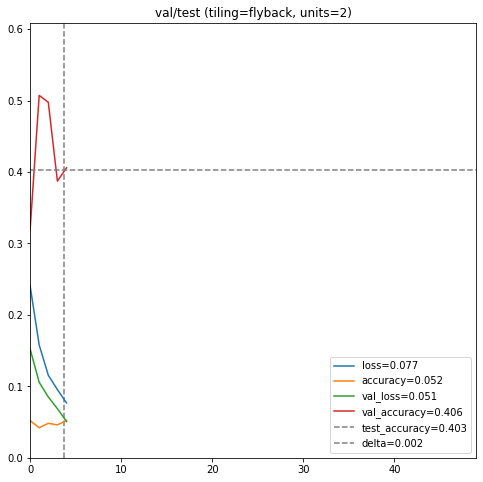

In [11]:
#@title
units = np.max(list(allhist.keys()))

fig, ax1 = plt.subplots(1,1, 
                         figsize=[8, 8], sharex=True, sharey=True)
units=2
tiling='flyback'
epochs=50
data = allhist[units][tiling]
plt.xlim([0.0, epochs-1])
plt.ylim([0.0, np.max(data['history']['val_accuracy']) * 1.2])
plot(ax1, units, tiling, data['history'], data['test_loss'], data['test_accuracy'], epochs, extra=True)


In [0]:
#@title
def plot_set(allhist, epochs, units_list):
    fig, rows = plt.subplots(len(units_list), 2, 
                            figsize=[6.0 * 2, 6.0 * len(units_list)], sharex=True, sharey=True)
    plt.xlim([0, epochs])
    plt.ylim([0.0, max_acc])
    row = 0
    tilings = ['flyback', 'hilbert']
    for units in units_list:
        for column in range(2):
            data = allhist[units][tilings[column]]
            ax = rows[row][column]
            plot(ax, units, tilings[column], data['history'], data['test_loss'], data['test_accuracy'], epochs, extra=False)
        row += 1


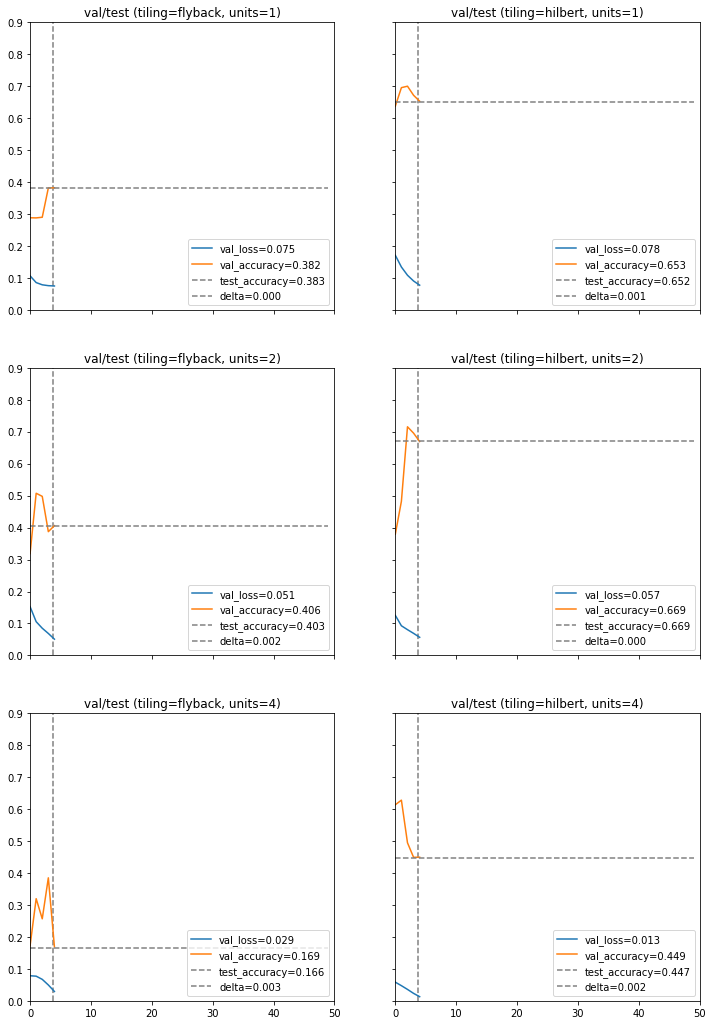

In [29]:
#@title
plot_set(allhist, 50, [1,2,4])

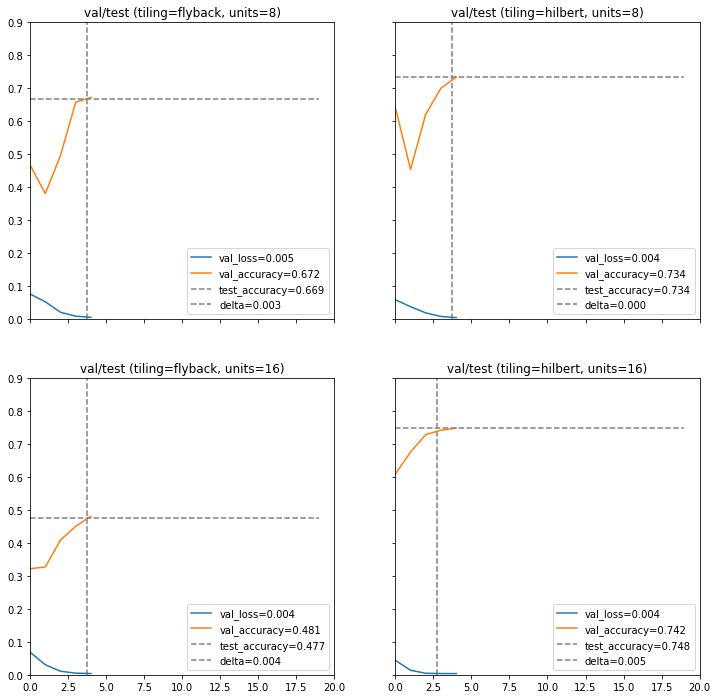

In [30]:
#@title
plot_set(allhist, 20, [8,16])

In [0]:
def show_samples(units, tiling):
    if units in allhist and tiling in allhist[units]:
        preds = allhist[units][tiling]['pix']
        print('predictions shape:', preds.shape)
        display1(preds, y_test[0:7])

16


<Figure size 432x288 with 0 Axes>

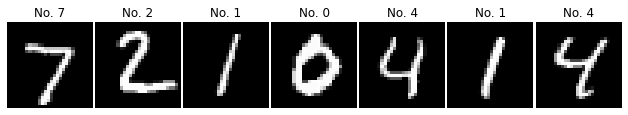

In [16]:
print(max(allhist))
display1(x_test[0:7], y_test[0:7])

predictions shape: (7, 32, 32)


<Figure size 432x288 with 0 Axes>

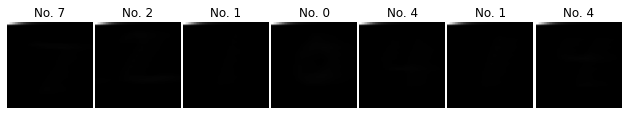

In [17]:
show_samples(1, 'flyback')

predictions shape: (7, 32, 32)


<Figure size 432x288 with 0 Axes>

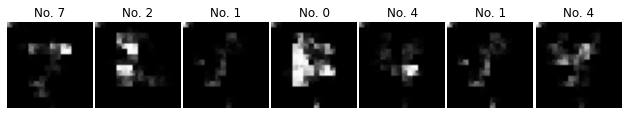

In [18]:
show_samples(1, 'hilbert')

predictions shape: (7, 32, 32)


<Figure size 432x288 with 0 Axes>

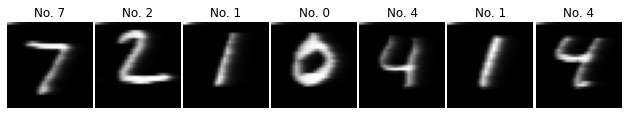

In [19]:
show_samples(2, 'flyback')

predictions shape: (7, 32, 32)


<Figure size 432x288 with 0 Axes>

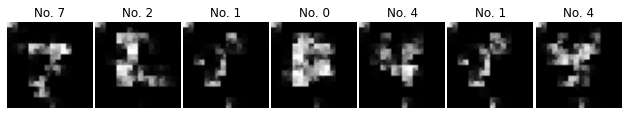

In [20]:
show_samples(2, 'hilbert')

predictions shape: (7, 32, 32)


<Figure size 432x288 with 0 Axes>

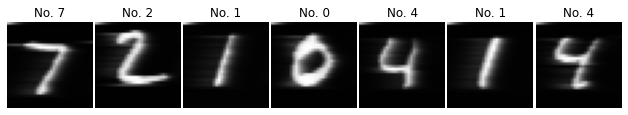

In [21]:
show_samples(4, 'flyback')

predictions shape: (7, 32, 32)


<Figure size 432x288 with 0 Axes>

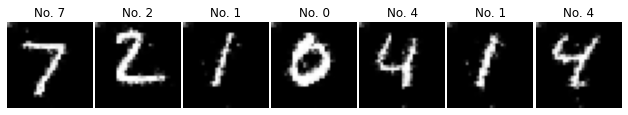

In [22]:
show_samples(4, 'hilbert')

predictions shape: (7, 32, 32)


<Figure size 432x288 with 0 Axes>

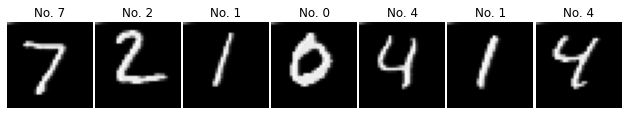

In [23]:
show_samples(8, 'flyback')

predictions shape: (7, 32, 32)


<Figure size 432x288 with 0 Axes>

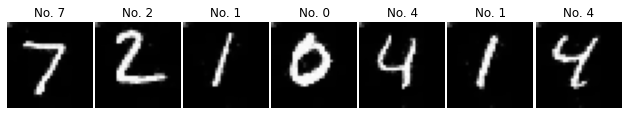

In [24]:
show_samples(8, 'hilbert')

predictions shape: (7, 32, 32)


<Figure size 432x288 with 0 Axes>

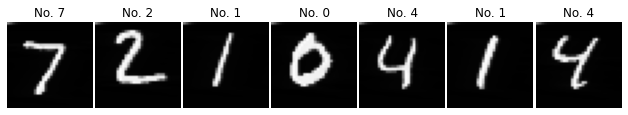

In [25]:
show_samples(16, 'flyback')

predictions shape: (7, 32, 32)


<Figure size 432x288 with 0 Axes>

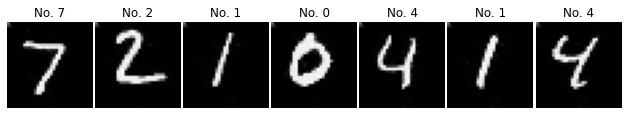

In [26]:
show_samples(16, 'hilbert')